<a href="https://colab.research.google.com/github/AdhishkumarT/GUVI-FP1/blob/main/fp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

In [11]:
# 2. Load Dataset
file_path = "/content/creditcard.csv"
df = pd.read_csv(file_path, on_bad_lines='skip', sep=',', engine='python')

In [12]:
# 3. Basic Exploration
print("DATASET INFO:")
print(df.info())
print("\nFIRST 5 ROWS:")
print(df.head())
print("\nMISSING VALUES:")
print(df.isnull().sum())
print("\nCLASS DISTRIBUTION:")
print(df['Class'].value_counts())


DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288794 entries, 0 to 288793
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    288794 non-null  float64
 1   V1      288794 non-null  float64
 2   V2      288794 non-null  float64
 3   V3      288794 non-null  float64
 4   V4      288794 non-null  float64
 5   V5      288794 non-null  float64
 6   V6      288794 non-null  float64
 7   V7      288794 non-null  float64
 8   V8      288794 non-null  float64
 9   V9      288794 non-null  float64
 10  V10     288794 non-null  float64
 11  V11     288794 non-null  float64
 12  V12     288794 non-null  float64
 13  V13     288794 non-null  float64
 14  V14     288794 non-null  float64
 15  V15     288794 non-null  float64
 16  V16     288794 non-null  float64
 17  V17     288794 non-null  float64
 18  V18     288794 non-null  float64
 19  V19     288794 non-null  float64
 20  V20     288794 non-null  float64
 

In [13]:
#handling missing values
df.fillna(df.median(), inplace=True)
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [15]:
#checking for duplicate values and removing
print("Checking for duplicate rows:")
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

Checking for duplicate rows:
5067
0


In [16]:
# Handling outliers in data
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outlier detection
threshold = 1.5
df_outliers_removed = df[~((df < (Q1 - threshold * IQR)) | (df > (Q3 + threshold * IQR))).any(axis=1)]

print(f"Dataset size before outlier removal: {df.shape}")
print(f"Dataset size after outlier removal: {df_outliers_removed.shape}")

Dataset size before outlier removal: (283727, 31)
Dataset size after outlier removal: (145938, 31)


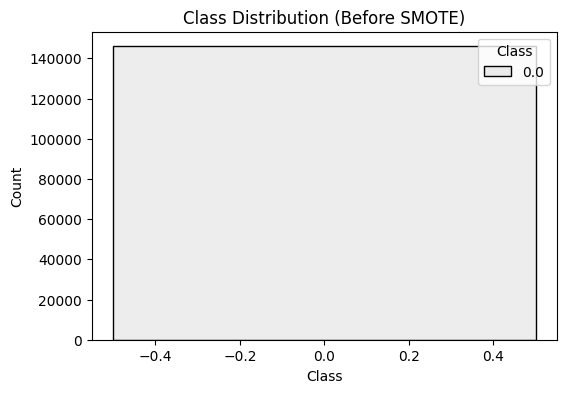

In [17]:
# Checking for Class Imbalance
plt.figure(figsize=(6,4))
sns.histplot(x='Class', data=df_outliers_removed, palette='coolwarm', hue='Class')
plt.title("Class Distribution (Before SMOTE)")
plt.show()

In [18]:
#Handling class imbalance by SMOTE
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [19]:
#class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y))

Class distribution before SMOTE: Counter({0.0: 283254, 1.0: 473})


In [20]:
# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution after SMOTE: Counter({0.0: 226603, 1.0: 113301})


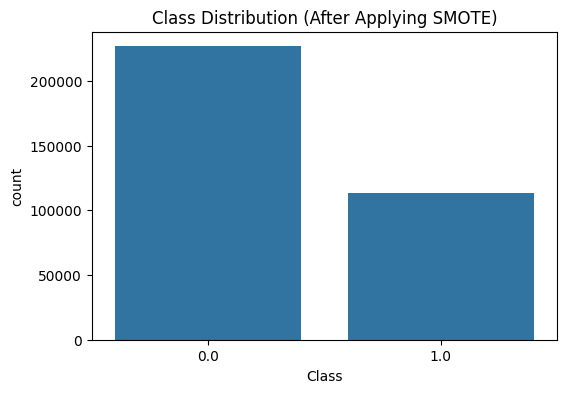

In [21]:
# Visualizing the new class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution (After Applying SMOTE)")
plt.show()

In [22]:
#feauture engineering

# Log Transformation of Amount (reduces skewness)
df_outliers_removed['Log_Amount'] = np.log1p(df_outliers_removed['Amount'])

# Extract Hour from Time column
df_outliers_removed['Transaction_Hour'] = (df_outliers_removed['Time'] // 3600) % 24

# Rolling Mean of Transaction Amount (last 3 transactions)
df_outliers_removed['Rolling_Amount_Mean'] = df_outliers_removed['Amount'].rolling(window=3, min_periods=1).mean()

# Transaction Amount Deviation (Z-score)
df_outliers_removed['Amount_Zscore'] = zscore(df_outliers_removed['Amount'])

# High-Risk Transaction Flag (Top 1% Amounts)
threshold = df_outliers_removed['Amount'].quantile(0.99)
df_outliers_removed['High_Risk_Flag'] = (df_outliers_removed['Amount'] > threshold).astype(int)

# Print first 5 rows to verify
print(df_outliers_removed[['Amount', 'Log_Amount', 'Transaction_Hour', 'Rolling_Amount_Mean', 'Amount_Zscore', 'High_Risk_Flag']].head())

# Transaction Amount Risk Score (based on percentile ranking)
df_outliers_removed['Amount_Risk_Score'] = df_outliers_removed['Amount'].rank(pct=True)

# Time Since Last Transaction (Detecting unusually rapid transactions)
df_outliers_removed['Time_Difference'] = df_outliers_removed['Time'].diff().fillna(0)

#Mean Transaction Amount per Customer (Deviation from Normal Spending)
df_outliers_removed['Mean_Amount_Per_User'] = df_outliers_removed.groupby('Transaction_Hour')['Amount'].transform('mean')

#Standard Deviation of Past Transactions (Fraudulent transactions often have high deviation)
df_outliers_removed['Std_Amount_Per_User'] = df_outliers_removed.groupby('Transaction_Hour')['Amount'].transform('std').fillna(0)

#Transaction Velocity (Number of Transactions in Last Hour)
df_outliers_removed['Transaction_Count_Last_Hour'] = df_outliers_removed.groupby('Transaction_Hour')['Amount'].transform('count')

#Print first 5 rows to verify
print(df_outliers_removed[['Amount', 'Amount_Risk_Score', 'Time_Difference', 'Mean_Amount_Per_User', 'Std_Amount_Per_User', 'Transaction_Count_Last_Hour']].head())


   Amount  Log_Amount  Transaction_Hour  Rolling_Amount_Mean  Amount_Zscore  \
0  149.62    5.014760               0.0           149.620000       2.731710   
1    2.69    1.305626               0.0            76.155000      -0.769866   
3  123.50    4.824306               0.0            91.936667       2.109229   
4   69.99    4.262539               0.0            65.393333       0.834000   
5    3.67    1.541159               0.0            65.720000      -0.746511   

   High_Risk_Flag  
0               0  
1               0  
3               0  
4               0  
5               0  
   Amount  Amount_Risk_Score  Time_Difference  Mean_Amount_Per_User  \
0  149.62           0.969028              0.0             29.297146   
1    2.69           0.213906              0.0             29.297146   
3  123.50           0.938758              1.0             29.297146   
4   69.99           0.824669              1.0             29.297146   
5    3.67           0.235107              0.0     

In [23]:
# Feature Scaling
scaler = RobustScaler()
X_resampled = scaler.fit_transform(X_train_resampled)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_train_resampled, test_size=0.2, random_state=42)

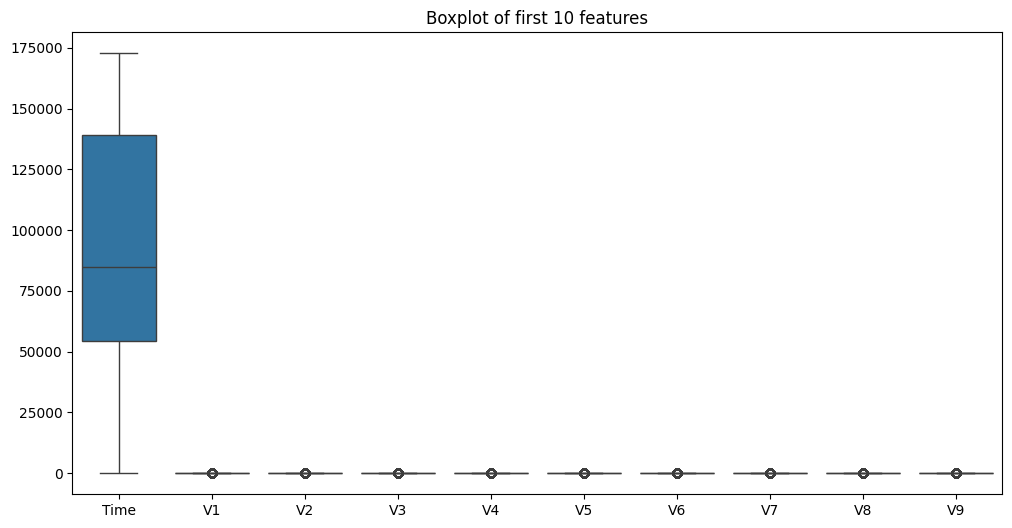

In [28]:
#Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=df.iloc[:, :10])
plt.title("Boxplot of first 10 features")
plt.show()

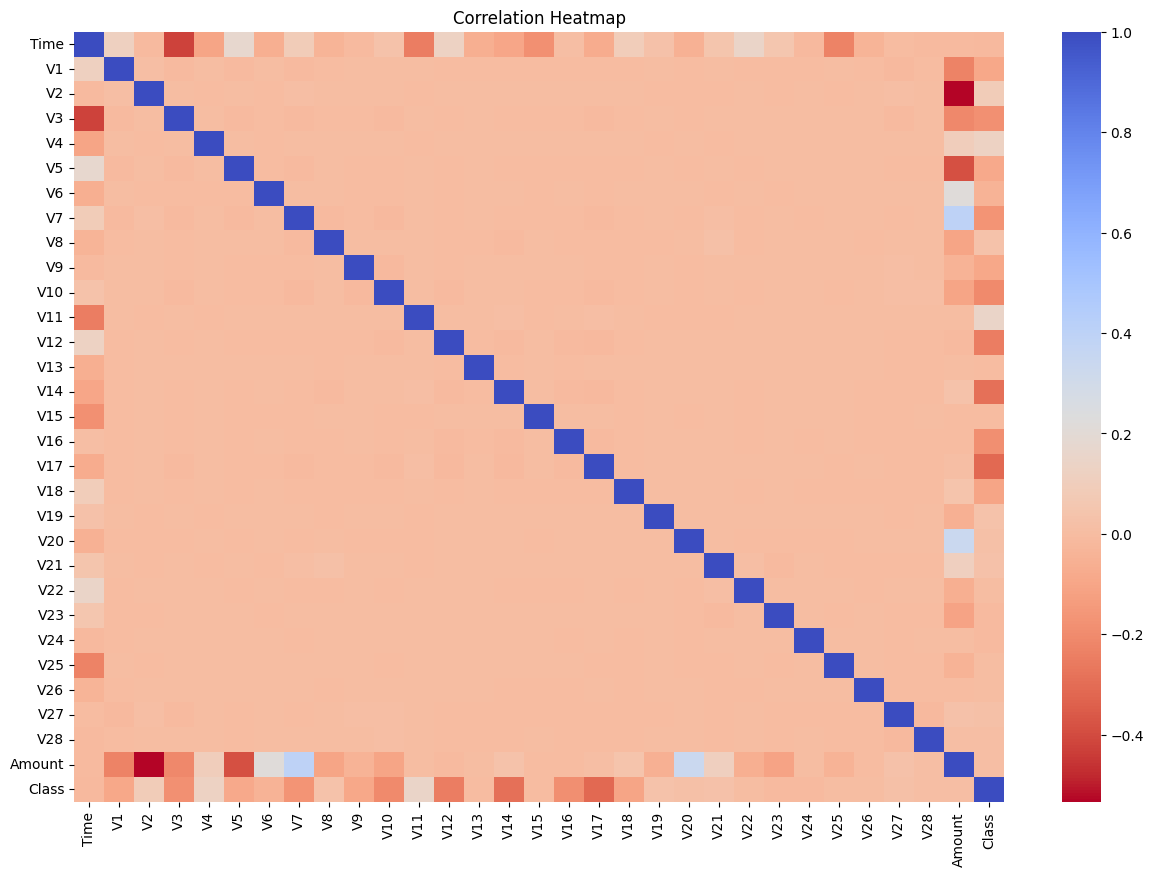

In [30]:
#Correlation Heatmap
plt.figure(figsize=(15, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title('Correlation Heatmap')
plt.show()


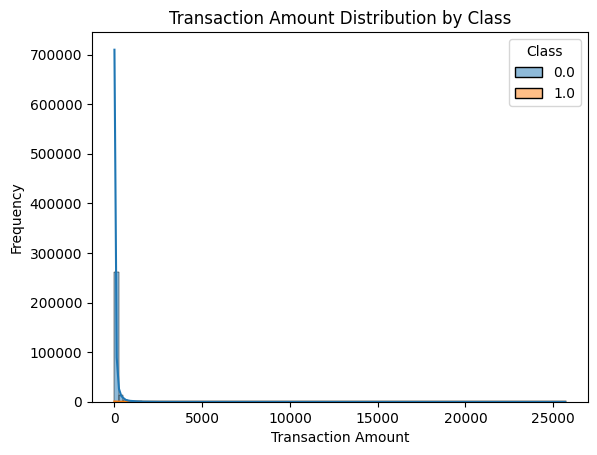

In [26]:
#Amount distribution by class
sns.histplot(data=df, x="Amount", hue="Class", bins=100, kde=True)
plt.title("Transaction Amount Distribution by Class")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


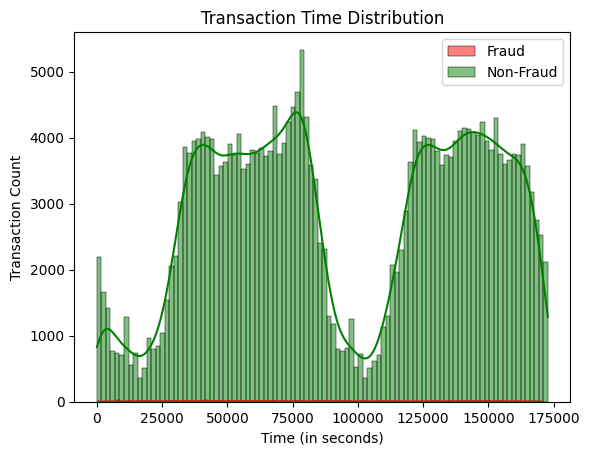

In [27]:
#Time vs Fraud Detection
sns.histplot(data=df[df['Class'] == 1], x='Time', bins=100, color='red', label='Fraud', kde=True)
sns.histplot(data=df[df['Class'] == 0], x='Time', bins=100, color='green', label='Non-Fraud', kde=True)
plt.title('Transaction Time Distribution')
plt.legend()
plt.xlabel("Time (in seconds)")
plt.ylabel("Transaction Count")
plt.show()

In [31]:
#ML MODELS
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [32]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [33]:
#Gradient Boosting Machine
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)

In [34]:
#Hyperparameter Tuning(Random Search CV)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2]
}

random_search = RandomizedSearchCV(XGBClassifier(), param_grid, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


In [35]:
#Deep Learning Models
#1)LSTM Model
X_train_dl = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_dl = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_dl.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, validation_data=(X_test_dl, y_test))

Epoch 1/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.9475 - loss: 0.1534 - val_accuracy: 0.9836 - val_loss: 0.0441
Epoch 2/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9838 - loss: 0.0447 - val_accuracy: 0.9920 - val_loss: 0.0224
Epoch 3/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 76s 9ms/step - accuracy: 0.9922 - loss: 0.0222 - val_accuracy: 0.9958 - val_loss: 0.0148
Epoch 4/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9980 - val_loss: 0.0081
Epoch 5/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.9976 - val_loss: 0.0081
Epoch 6/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9974 - val_loss: 0.0091
Epoch 7/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9980 - val_loss: 0.0067
Epoch 8/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - accuracy: 0.9982 - loss: 0

In [36]:
#2)RNN Model
rnn_model = Sequential([
    layers.SimpleRNN(64, input_shape=(X_train_dl.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    layers.SimpleRNN(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, validation_data=(X_test_dl, y_test))

Epoch 1/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - accuracy: 0.9749 - loss: 0.0754 - val_accuracy: 0.9871 - val_loss: 0.0390
Epoch 2/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9913 - loss: 0.0263 - val_accuracy: 0.9965 - val_loss: 0.0125
Epoch 3/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9931 - loss: 0.0228 - val_accuracy: 0.9955 - val_loss: 0.0147
Epoch 4/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9920 - loss: 0.0279 - val_accuracy: 0.9949 - val_loss: 0.0191
Epoch 5/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.9915 - val_loss: 0.0285
Epoch 6/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9906 - loss: 0.0297 - val_accuracy: 0.9918 - val_loss: 0.0264
Epoch 7/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9910 - loss: 0.0301 - val_accuracy: 0.9924 - val_loss: 0.0263
Epoch 8/10
8498/8498 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9891 - loss: 0

In [37]:
#3)GAN Model
def build_generator():
    model = Sequential([
        Dense(128, activation="relu", input_dim=X_train.shape[1]),
        Dense(256, activation="relu"),
        Dense(X_train.shape[1], activation="sigmoid")
    ])
    return model

def build_discriminator():
    model = Sequential([
        Dense(256, activation="relu", input_dim=X_train.shape[1]),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

gan = Sequential([generator, discriminator])

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss="binary_crossentropy", metrics=["accuracy"])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss="binary_crossentropy")

In [38]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUROC: {roc_auc:.4f}")

In [39]:
# Evaluate all models
evaluate_model(dt, X_test, y_test, "Decision Tree")
evaluate_model(xgb, X_test, y_test, "XGBoost")
evaluate_model(gbm, X_test, y_test, "Gradient Boosting Machine")
evaluate_model(random_search.best_estimator_, X_test, y_test, "Tuned XGBoost")
evaluate_model(lstm_model, X_test_dl, y_test, "LSTM Model")
evaluate_model(rnn_model, X_test_dl, y_test, "RNN Model")
evaluate_model(gan, X_test_dl, y_test, "GAN Model")


Model: Decision Tree
Accuracy: 0.9976
Precision: 0.9951
Recall: 0.9979
F1 Score: 0.9965
AUROC: 0.9977

Model: XGBoost
Accuracy: 0.9998
Precision: 0.9995
Recall: 1.0000
F1 Score: 0.9998
AUROC: 0.9999

Model: Gradient Boosting Machine
Accuracy: 0.9893
Precision: 0.9935
Recall: 0.9743
F1 Score: 0.9838
AUROC: 0.9855

Model: Tuned XGBoost
Accuracy: 0.9997
Precision: 0.9992
Recall: 1.0000
F1 Score: 0.9996
AUROC: 0.9998
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

Model: LSTM Model
Accuracy: 0.9992
Precision: 0.9978
Recall: 0.9999
F1 Score: 0.9988
AUROC: 0.9994
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Model: RNN Model
Accuracy: 0.9892
Precision: 0.9867
Recall: 0.9809
F1 Score: 0.9838
AUROC: 0.9871
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Model: GAN Model
Accuracy: 0.3337
Precision: 0.3337
Recall: 1.0000
F1 Score: 0.5004
AUROC: 0.5000


In [40]:
# Evaluate Model Performance
print("\n Decision Tree model performance")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("AUROC Score:", roc_auc_score(y_test, y_pred_dt))

print("\n XGBoost Model Performance ")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUROC Score:", roc_auc_score(y_test, y_pred_xgb))

print("\n GBM Model Performance ")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gbm))
print("AUROC Score:", roc_auc_score(y_test, y_pred_gbm))



 Decision Tree model performance
Confusion Matrix:
 [[45182   112]
 [   48 22639]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45294
         1.0       1.00      1.00      1.00     22687

    accuracy                           1.00     67981
   macro avg       1.00      1.00      1.00     67981
weighted avg       1.00      1.00      1.00     67981

AUROC Score: 0.9977057585985848

 XGBoost Model Performance 
Confusion Matrix:
 [[45283    11]
 [    0 22687]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45294
         1.0       1.00      1.00      1.00     22687

    accuracy                           1.00     67981
   macro avg       1.00      1.00      1.00     67981
weighted avg       1.00      1.00      1.00     67981

AUROC Score: 0.9998785711131718

 GBM Model Performance 
Confusion Matrix:
 [[45150   144]
 [  584 22

In [42]:
joblib.dump(dt, 'decision_tree_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
joblib.dump(gbm, 'gradient_boosting_model.pkl')
joblib.dump(random_search.best_estimator_, 'tuned_xgboost_model.pkl')
lstm_model.save('lstm_model.h5')
rnn_model.save('rnn_model.h5')
gan.save('gan_model.h5')